In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def T(masses, velocities):
    return torch.sum(0.5 * masses * torch.norm(velocities, dim=1) ** 2)

def V(masses, positions):
    V_total = 0.0
    num_bodies = len(masses)
    for i in range(num_bodies):
        for j in range(i + 1, num_bodies):
            r_ij = torch.norm(positions[i] - positions[j])
            V_total -= masses[i] * masses[j] / r_ij
    return V_total.sum()  # Ensure this is a scalar

def H(masses, positions, velocities):
    return T(masses, velocities) + V(masses, positions)

In [ ]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, physical_output_dim, num_bodies=3):
        super(PINN, self).__init__()
        self.num_bodies = num_bodies  
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )

        
        # Position subnetwork
        self.position_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, physical_output_dim)
        )

        # Velocity subnetwork
        self.velocity_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, physical_output_dim)
        )

        # Acceleration subnetwork
        self.acceleration_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, physical_output_dim)
        )

        self.potential_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x, masses):
        batch_size = x.shape[0]  # Get batch size dynamically
        shared_features = self.shared_layers(x)
        
        position_pred = self.position_net(shared_features)
        velocity_pred = self.velocity_net(shared_features)
        acceleration_pred = self.acceleration_net(shared_features)
        potential_pred = self.potential_net(shared_features)
        
        dim = position_pred.shape[-1] // self.num_bodies  # Expected dimension per body
        velocity_pred_reshaped = velocity_pred.view(batch_size, self.num_bodies, dim)

        kinetic_pred = 0.5 * torch.sum(masses.unsqueeze(-1) * (velocity_pred_reshaped**2), dim=(1,2))  # Sum over bodies and dimensions

        hamiltonian_pred = (potential_pred.squeeze() + kinetic_pred).sum()
        
        return position_pred, velocity_pred, acceleration_pred, hamiltonian_pred

    
input_dim = 3*9 + 3 + 1 # 3 bodies, 9 vectors per each body (3 positions, 3 velocities, 3 accelerations), 3 masses, time
hidden_dim = 256
physical_output_dim = 9

model = PINN(input_dim, hidden_dim, physical_output_dim)

In [ ]:
def energy_loss(hamiltonian_pred, hamiltonian_true):
    return torch.abs(hamiltonian_pred - hamiltonian_true).mean()

def residual_loss(masses, positions_pred, velocities_pred, accelerations_pred):
    H_total = H(masses, positions_pred, velocities_pred).sum()  # Ensure H is a scalar

    grad_H_v = torch.autograd.grad(H_total, velocities_pred, create_graph=True, retain_graph=True)[0]
    grad_H_r = torch.autograd.grad(H_total, positions_pred, create_graph=True, retain_graph=True)[0]

    residual_v = torch.norm(grad_H_v / masses.unsqueeze(-1) - velocities_pred, dim=(1,2)).mean()
    residual_a = torch.norm(-grad_H_r / masses.unsqueeze(-1) - accelerations_pred, dim=(1,2)).mean()
    
    return residual_v + residual_a


def leapfrog_loss(masses, positions_pred, velocities_pred, positions_true, velocities_true, dt):
    positions_true = positions_true.clone().detach().requires_grad_(True)  # Ensure tracking for gradients

    p_0_true = masses.unsqueeze(1) * velocities_true
    gradient_V_0 = torch.autograd.grad(V(masses, positions_true), positions_true, create_graph=True, retain_graph=True)[0]

    p_half = p_0_true - (0.5 * dt * gradient_V_0)
    positions_leapfrog = positions_true + dt * (p_half / masses.unsqueeze(1))
    
    positions_leapfrog = positions_leapfrog.clone().detach().requires_grad_(True)  # Ensure tracking for new positions
    gradient_V_new = torch.autograd.grad(V(masses, positions_leapfrog), positions_leapfrog, create_graph=True, retain_graph=True)[0]

    p_new = p_half - (0.5 * dt * gradient_V_new)
    velocities_leapfrog = p_new / masses.unsqueeze(1)

    position_error = torch.norm(positions_pred - positions_leapfrog, dim=(1,2)).mean()
    velocity_error = torch.norm(velocities_pred - velocities_leapfrog, dim=(1,2)).mean()

    return position_error + velocity_error


def loss_fn(z_true, hamiltonian_true, z_pred, lambda_energy, lambda_residual, lambda_leapfrog, masses, dt):
    positions_true, velocities_true, accelerations_true = z_true
    positions_pred, velocities_pred, accelerations_pred, hamiltonian_pred = z_pred
    
    loss_energy = energy_loss(hamiltonian_pred, hamiltonian_true)
    loss_residual = residual_loss(masses, positions_pred, velocities_pred, accelerations_pred)
    loss_leapfrog = leapfrog_loss(masses, positions_pred, velocities_pred, positions_true, velocities_true, dt)
    
    return (lambda_energy * loss_energy + 
            lambda_residual * loss_residual + 
            lambda_leapfrog * loss_leapfrog)

In [62]:
# Function to generate mock data
def generate_mock_data(batch_size=32, num_bodies=3, dim=3, dt=0.01):
    masses = torch.rand((batch_size, num_bodies)) * 5 + 1  # Random masses between 1 and 6
    positions = torch.randn((batch_size, num_bodies, dim)) * 10  # Random positions
    velocities = torch.randn((batch_size, num_bodies, dim))  # Random velocities
    accelerations = torch.randn((batch_size, num_bodies, dim)) * 0.1  # Small accelerations
    times = torch.rand((batch_size, 1)) * 10  # Random time values

    # Compute the Hamiltonian using the defined physics functions
    hamiltonians = torch.tensor([H(masses[i], positions[i], velocities[i]) for i in range(batch_size)])

    return positions, velocities, accelerations, masses, times, hamiltonians

# Training loop
def train(model, epochs=1000, batch_size=32, lr=1e-3, lambda_energy=1.0, lambda_residual=1.0, lambda_leapfrog=1.0, dt=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        positions, velocities, accelerations, masses, times, hamiltonians = generate_mock_data(batch_size=batch_size)

        # Flatten inputs for model
        input_data = torch.cat([times, masses, positions.view(batch_size, -1), velocities.view(batch_size, -1), accelerations.view(batch_size, -1)], dim=1)

        # Forward pass
        positions_pred, velocities_pred, accelerations_pred, hamiltonian_pred = model(input_data, masses)

        # Reshape predicted outputs
        positions_pred = positions_pred.reshape(batch_size, 3, 3)
        velocities_pred = velocities_pred.reshape(batch_size, 3, 3)
        accelerations_pred = accelerations_pred.reshape(batch_size, 3, 3)

        z_true = (positions, velocities, accelerations)
        z_pred = (positions_pred, velocities_pred, accelerations_pred, hamiltonian_pred)

        # Compute loss
        loss = loss_fn(z_true, hamiltonians, z_pred, lambda_energy, lambda_residual, lambda_leapfrog, masses, dt)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            
# Hyperparameters
epochs = 500
batch_size = 32
lr = 1e-3
dt = 0.01

# Train the model
train(model, epochs=epochs, batch_size=batch_size, lr=lr, dt=dt)

Epoch 0, Loss: 40.53019714355469
Epoch 100, Loss: 27.346534729003906
Epoch 200, Loss: 15.18781852722168
Epoch 300, Loss: 19.797901153564453
Epoch 400, Loss: 16.004657745361328


Validation Results - Position Error: 4.3897, Velocity Error: 2.1572


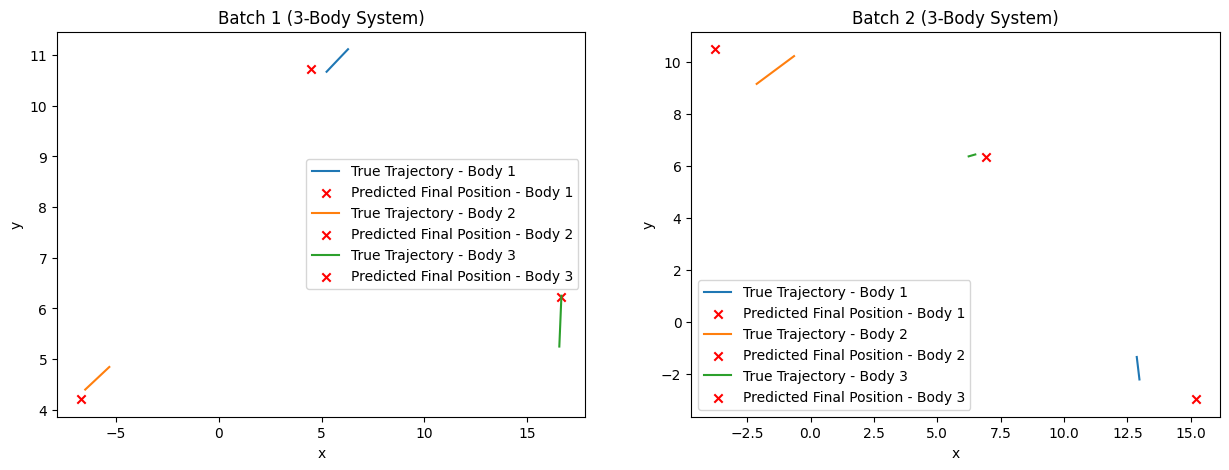

In [82]:
def leapfrog_integrator(masses, positions, velocities, dt, steps):

    positions_traj = [positions.clone()]
    velocities_traj = [velocities.clone()]

    for _ in range(steps):
        positions.requires_grad_(True)  # Needed for gradient computation

        # Compute force from potential energy
        potential_energy = V(masses, positions).sum()  # Ensure scalar
        grad_V = torch.autograd.grad(potential_energy, positions, create_graph=True)[0]

        # Leapfrog integration step
        velocities_half = velocities - 0.5 * dt * grad_V / masses.unsqueeze(-1)
        positions_new = positions + dt * velocities_half
        positions_new.requires_grad_(True)

        potential_energy_new = V(masses, positions_new).sum()
        grad_V_new = torch.autograd.grad(potential_energy_new, positions_new, create_graph=True)[0]
        velocities_new = velocities_half - 0.5 * dt * grad_V_new / masses.unsqueeze(-1)

        positions, velocities = positions_new.detach(), velocities_new.detach()

        positions_traj.append(positions.clone())
        velocities_traj.append(velocities.clone())

    return torch.stack(positions_traj, dim=1), torch.stack(velocities_traj, dim=1)

# Validation Function
def validate(model, batch_size=5, num_steps=100, dt=0.01):
    positions, velocities, accelerations, masses, times, _ = generate_mock_data(batch_size=batch_size)

    input_data = torch.cat([times, masses, positions.view(batch_size, -1), velocities.view(batch_size, -1), accelerations.view(batch_size, -1)], dim=1)

    with torch.no_grad():
        positions_pred, velocities_pred, _, _ = model(input_data, masses)

    positions_pred = positions_pred.view(batch_size, 3, 3)
    velocities_pred = velocities_pred.view(batch_size, 3, 3)

    # Solve numerically using Leapfrog integration
    positions_true, velocities_true = leapfrog_integrator(masses, positions, velocities, dt, num_steps)

    # Compute Errors (Mean Squared Error)
    position_error = torch.norm(positions_true[:, -1] - positions_pred, dim=(1,2)).mean().item()
    velocity_error = torch.norm(velocities_true[:, -1] - velocities_pred, dim=(1,2)).mean().item()

    print(f"Validation Results - Position Error: {position_error:.4f}, Velocity Error: {velocity_error:.4f}")

    # Plot trajectories
    fig, ax = plt.subplots(1, batch_size, figsize=(15, 5))  # One subplot per batch

    if batch_size == 1:
        ax = [ax]  # Ensure ax is iterable

    for i in range(batch_size):  # Iterate over each batch
        for b in range(3):  # Iterate over all 3 bodies
            ax[i].plot(
                positions_true[i, :, b, 0].cpu(), 
                positions_true[i, :, b, 1].cpu(), 
                label=f"True Trajectory - Body {b+1}"
            )
            ax[i].scatter(
                positions_pred[i, b, 0].cpu(), 
                positions_pred[i, b, 1].cpu(), 
                marker="x", color="red", 
                label=f"Predicted Final Position - Body {b+1}"
            )

        ax[i].set_title(f"Batch {i+1} (3-Body System)")
        ax[i].set_xlabel("x")
        ax[i].set_ylabel("y")
        ax[i].legend()

    


# Run Validation after Training
validate(model, batch_size=2, num_steps=100, dt=0.01)
